# Internal Inconsistencies

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display
import import_ipynb
import data_preperation as dp
import copy
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import openpyxl

importing Jupyter notebook from data_preperation.ipynb


In [2]:
countries={ 'Austria': 'AT', 'Belgium': 'BE',  'Bulgaria': 'BG', 'Switzerland': 'CH', 'Czech Republic': 'CZ', 'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Spain': 'ES', 'Finland': 'FI', 'France': 'FR',  'Greece': 'GR', 'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Lithuania': 'LT', 'Latvia': 'LV', 'Montenegro': 'ME','Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Serbia': 'RS', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovakia': 'SK', 'United Kingdom': 'GB'}
abbr_list=list(countries.values())

# 1. Internal inconsistencies based on unedited ENTSO-E data

## 1.1 Calculating missing values and mismatch analysis in data files

In [6]:
def length_of_missing_observations(df, length, calc):

    # The following function checks the length of the missing observations in the entire dataframe.
    # 'size' variable calculates the total number of observations in the dataframe including the null values.
    # Then update the number of missing observations in each time length in the 'calc' dictionary. 'calc' dictionary is explained in below 'mismatch_raw_data' function
    # After calculating the whole dataframe, the obtained values are divided by 'size' to get the percentage value with respect to the total observations in the dataset.
    # Then returns the 'calc' values
    
    size = df.shape[0]*df.shape[1]
    for column in df.columns.values:
        i = 0
        counter = 0
        while i < len(df[column]):
            if pd.isnull(df.loc[i, column]) and i == len(df[column])-1:
                counter += 1
            if pd.isnull(df.loc[i, column]) and i != len(df[column])-1:
                counter += 1
            elif counter == 1:
                calc['Single observations'] += counter
                counter = 0
            elif counter > 1 and counter <= 24*length:
                calc['Consecutive Multiple hours in 1 day'] += counter
                counter = 0
            elif counter > 24*length and counter <= 24*30*length:
                calc['More than 1 day less than 1 month'] += counter
                counter = 0
            elif counter > 24*30*length and counter < len(df[column]):
                calc['More than 1 month less than whole year'] += counter
                counter = 0
            if counter == len(df[column]):
                calc['Whole year'] += counter
            i += 1
    for key, value in calc.items():
        calc[key] = round(value*100/size, 3)
    return calc

def mismatch_raw_data(countries):

    types = ['Load', 'Generation', 'Transmission']
    columns = ['Country']

    # 'calc' dictionary saves the number of missing observations in each column in each length category. These length categoroes are 'The number of single missing observations','Number of missing observations in consecutive multiple hours in 1a single day','Number of missing observations in a time period of more than 1 month' and 'Number of missing observations when the data of the whole column is missing'

    calc = {'Single observations': 0, 'Consecutive Multiple hours in 1 day': 0,
        'More than 1 day less than 1 month': 0, 'More than 1 month less than whole year': 0, 'Whole year': 0}
    for type in types:
        for item in calc.keys():
            columns.append(f'{type}_{item}')
    df = pd.DataFrame(columns=columns)

    transmission_data = pd.DataFrame()
    rows = []

    mismatch_data = {}
    temp = pd.DataFrame()
    csvs = glob.glob("../Data Sources/ENTSO-E/2018/Transmission/*.csv")

    # In the following command we read each csv file and drop the rows related to day light saving using 'omit_dst' function
    # We create a new dataframe 'transmission_data_temp' with all the columns in all the csvs attached together.
    # We apend the 'rows' list with string edited column names of the 'temp' dataframe and number of N/A values in that column.
    # Then we cretae two new column in the 'transmission_data' dataframe and name it as the two country codes the power transmission occurs.
    # We use string editing to get the two country codes from the file path.
    # Then we convert the 'rows' to a dataframe called 'transmission_missing_data' 
    # We read Load and Generation csvs and send them to 'length_of_missing_observations' function to get the missing observations information.
    # We update the 'row' Array with the information of missing observations obtained from the 'length_of_missing_observations' function.
    # Then we make a list with all the column names of 'transmission_data' if the country abbreviation is in that column head.
    # Then we make a list of column heads of imports and exports associated with a given country_abbreviation
    # We calculate the annual data mismatch of each country as (generation + imports - load - exports) of the country and save that in 'mismatch_data' dictionary with the country abbreviation as the key.
    # Countries provide the data in 15 min, 30 min and 1 hour intervals.
    # Therefore in 'mismatch_data' variable, to ge the energy values from the power values, we divide the total power data by 4,2 or 1 using the 'divider' variable as required.
    # After sorting the 'mismatch_data' by values, graph is drawn.

    for csv in csvs:

        temp, divider_transmission = dp.omit_dst(pd.read_csv(csv))
        rows.append([f'{csv[42:44]} - > {csv[45:47]}',temp.iloc[:, 2].isnull().sum()])
        rows.append([f'{csv[45:47]} - > {csv[42:44]}',temp.iloc[:, 1].isnull().sum()])

        transmission_data[f'{csv[42:44]} - > {csv[45:47]}'] = pd.to_numeric(temp.iloc[:, 2],errors='coerce')/divider_transmission
        transmission_data[f'{csv[45:47]} - > {csv[42:44]}'] = pd.to_numeric(temp.iloc[:, 1],errors='coerce')/divider_transmission
  
    for country,abbr in countries.items():

        row = []

        load_data,divider_load = dp.omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Load/{country}.csv').iloc[:,2:])
        row.append((length_of_missing_observations(load_data,divider_load,calc.copy())).values())

        generation_data,divider_gen = dp.omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv').iloc[:,2:])
        generation_data = generation_data.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)
        row.append((length_of_missing_observations(generation_data,divider_gen,calc.copy())).values())

        transmission=[x for x in transmission_data.columns.values if abbr in x]
        imports = [x for x in transmission_data.columns.values if abbr in x[-2:]]
        exports = [x for x in transmission_data.columns.values if abbr in x[:2]]
        row.append((length_of_missing_observations(transmission_data[transmission],divider_transmission,calc.copy())).values())
        row = [x for item in row for x in item]
        row.insert(0, abbr)
        row = ['-' if x==0 else x for x in row]
        row_series = pd.Series(row, index=df.columns)
        df = df.append(row_series, ignore_index=True)

        mismatch_data[abbr] = round(abs(generation_data.iloc[:,:].sum(axis=1).sum()/divider_gen + transmission_data[imports].sum(
                axis=1).sum() - load_data.iloc[:,0].sum()/divider_load - transmission_data[exports].sum(axis=1).sum()), 2)/1000000

    mismatch_data = sorted(mismatch_data.items(), key= lambda item: item[1], reverse=True)

    width = 0.35
    labels = [item[0] for item in mismatch_data]
    X = np.arange(len(labels))
    plt.figure(figsize=(20,10))
    plt.bar([x for x in X], [item[1] for item in mismatch_data], width, color='aqua',edgecolor='black')
    plt.xlabel('Countries')
    plt.ylabel('Mismatch [TWh]')
    plt.title('Mismatch analysis based on (generation + imports - load - exports) in raw ENTSO-E data')
    plt.grid()
    plt.axhline(y=0, color='black', linestyle='-')
    plt.xticks(X,labels)
    plt.show()

    return df


BE Hydro Pumped Storage  - Actual Aggregated [MW] 6520
BE Wind Offshore  - Actual Aggregated [MW] 2966
BE Wind Offshore  - Actual Aggregated [MW] 4934
BE Wind Offshore  - Actual Aggregated [MW] 5151
BE Wind Offshore  - Actual Aggregated [MW] 5851
BG Actual Total Load [MW] - Bulgaria (BG) 7223
BG BG - > MK 1991
BG BG - > MK 2206
BG BG - > MK 7343
BG MK - > BG 1991
BG MK - > BG 2206
BG MK - > BG 7343
BG BG - > TR 1991
BG BG - > TR 2206
BG BG - > TR 7343
BG TR - > BG 1991
BG TR - > BG 2206
BG TR - > BG 7343
FR Fossil Hard coal  - Actual Aggregated [MW] 1683
FR Fossil Hard coal  - Actual Aggregated [MW] 2353
FR Fossil Hard coal  - Actual Aggregated [MW] 4531
FR Fossil Hard coal  - Actual Aggregated [MW] 8544
FR Fossil Hard coal  - Actual Aggregated [MW] 8593
FR Hydro Pumped Storage  - Actual Aggregated [MW] 2022
HU Fossil Oil  - Actual Aggregated [MW] 430
HU Fossil Oil  - Actual Aggregated [MW] 529
HU Fossil Oil  - Actual Aggregated [MW] 1077
HU Fossil Oil  - Actual Aggregated [MW] 1381
HU

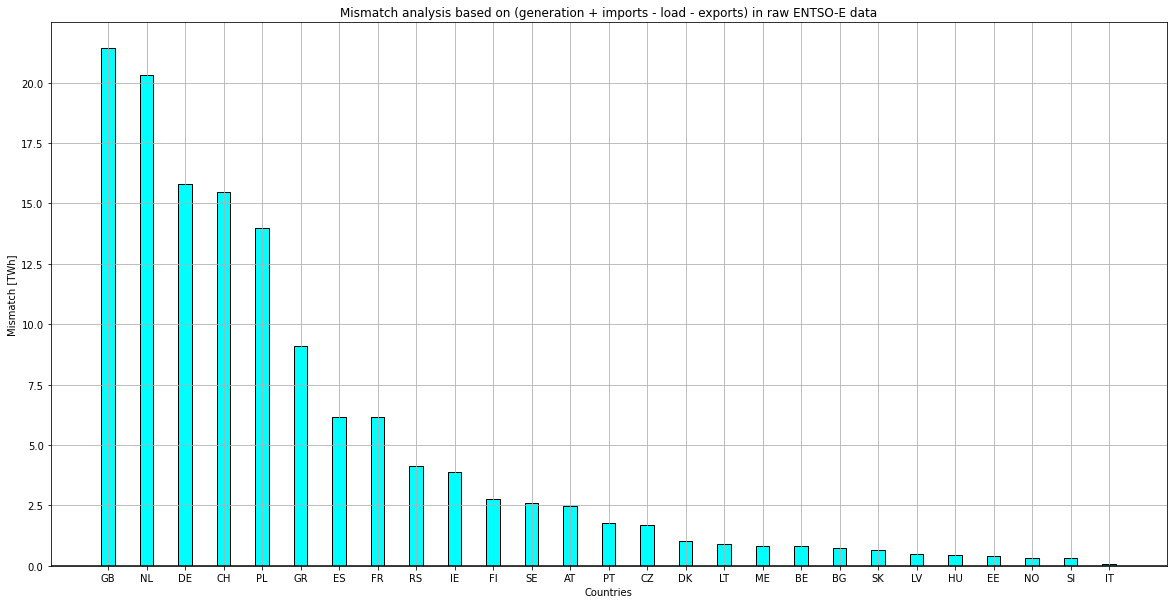

,Country,Load_Single observations,Load_Consecutive Multiple hours in 1 day,Load_More than 1 day less than 1 month,Load_More than 1 month less than whole year,Load_Whole year,Generation_Single observations,Generation_Consecutive Multiple hours in 1 day,Generation_More than 1 day less than 1 month,Generation_More than 1 month less than whole year,Generation_Whole year,Transmission_Single observations,Transmission_Consecutive Multiple hours in 1 day,Transmission_More than 1 day less than 1 month,Transmission_More than 1 month less than whole year,Transmission_Whole year
0,AT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,BE,-,-,-,-,-,0.122,2.648,0.08,-,-,-,-,-,-,-
2,BG,-,-,0.285,-,-,-,-,-,-,-,-,0.114,1.863,-,-
3,CH,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,CZ,0.034,0.046,-,-,-,0.02,0.003,-,-,-,-,-,-,-,-
5,DE,-,-,-,-,-,-,-,-,4.973,-,-,0.023,-,-,-
6,DK,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
7,EE,1.381,0.263,-,-,-,1.149,0.144,-,-,-,2.114,2.135,-,4.193,-
8,ES,0.023,-,-,-,-,0.011,-,-,-,5.0,-,-,-,-,-
9,FI,0.011,0.023,-,-,-,0.003,0.013,-,-,-,0.535,0.077,-,-,-


In [7]:
mismatch_raw_data(countries)


# 2. Identifying inconsistencies in Generation data of ENTSO-E

In [4]:
def inconcistencies_generation_data():    
    csvs = glob.glob("../Data Sources/ENTSO-E/2018/Generation/Generation per unit/*.csv")
    data = []

    # The data obtained of the data item 'Actual Generation Output per Generation' in cvs format are saved in '../Data Sources/ENTSO-E/2018/Generation/Generation per unit' folder
    # The data obtained of the data item 'Aggregated Generation per Type' in cvs format are saved in '../Data Sources/ENTSO-E/2018/Generation' folder
    # We get a list of paths of csv files in the first folder using glob function.
    # Using the path name, respective 'Aggregated Generation per Type' csv of the 'Actual Generation Output per Generation' file is opened with variable name 'df_type' and sent it to 'omit_dst' function.
    # Then in every column is renamed by removing the ' Actual Aggregated [MW]' part of the column name.
    # Then we open the relevant'Aggregated Generation per Type' csv with variable name 'df_gen'.
    # In the 'df_gen' file, if 'Actual Consumption' columns are available, such columns are dropped only keeping the 'Actual Aggregated' columns.
    # If 'df_gen' has 'Actual Consumption' columns, then we remove the first row and reset the index of the dataframe.
    # Then we replace 'n/e' and null values with 0 and transpose the dataframe.
    # In the transposed dataframe we get the set of generation type names from the 1st column to the 'generation_types' variable.
    # Then we group the 'df_gen' using the 1st column.
    # By iterating through each generation type we get a subgroup of the 'df_gen' filtered by the generation type.
    # This subgroup contains only the data related to the power plants of that particular generation type.
    # We get the sum of all the columns (Sum of all the power values of the power plants of that particular generation type)
    # Then we append the 'data' list with country_name, generation_type, sum value of previous step and sum of the column of that particular generation type in 'df_type' dataframe.
    # Finally we convert this list to a dataframe.

    for csv in csvs:

        df_type,length = dp.omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{csv[60:-4]}.csv', low_memory=False).iloc[:,2:])
        df_type = df_type.replace('n/e', 0)
        columns = [column[:-26] for column in df_type.columns.values]
        df_type.columns = columns

        df_gen = pd.read_csv(csv,low_memory=False).iloc[:, 1:]

        inc = False
        for column in df_gen.columns.values:
            if df_gen.loc[1, column] == 'Actual Consumption':
                df_gen = df_gen.drop(column, axis=1)
                inc = True
        if inc:
            df_gen = df_gen.drop(index=1).reset_index(drop=True)

        df_gen = df_gen.replace(['n/e', np.nan], 0)
        df_gen = df_gen.T

        generation_types = list(set(df_gen.iloc[:, 0].values))
        df_gen = df_gen.groupby(df_gen.iloc[:, 0])
        for item in generation_types:
            selected_data = df_gen.get_group(item).iloc[:, 1:]
            tot = 0
            for column in selected_data.columns.values:
                tot += pd.to_numeric(selected_data.loc[:, column]).sum()
            # print(csv[60:-4], item, tot, df_type.loc[:, item].sum()/length)
            data.append([csv[60:-4], item, tot, df_type.loc[:, item].sum()/length])

    df = pd.DataFrame(data,columns=['Country','Generation type','Based on per generator','Based on per type'])

    return df


# 3. Consolidation based on internally gap filled ENTSO-E data

## 3.1 Optimization based internal approach

In [5]:
def sigma(load_dic, generation_dic, transmission_data, countries):

    abbr_list = list(countries.values())
    load_dic_copy = copy.deepcopy(load_dic)
    generation_dic_copy = copy.deepcopy(generation_dic)

    # We filter the transmission links between given two countries in which if both countries associated with the power transmission are included in our country_abbreviation list.
    # For example power import(export) occurs from(to) a country other than the countries in the abbreviation_list (for ex: 'Cyprus','Turkey' etc.) are omitted.

    transmission_lines = list([x for x in transmission_data.columns.values if x[:2] in abbr_list and x[-2:] in abbr_list])
    transmission_data = transmission_data[transmission_lines]
    transmission_data_copy = copy.deepcopy(transmission_data)

    # In the following command, we calculate the sigma value by sending it to 'data_preperation.ipynb'

    sigma = dp.calculate_sigma(load_dic_copy, generation_dic_copy, transmission_data_copy, abbr_list)
    print('SIGMA CALCULATED')

    # In the follwoing commands we create a 'country_index' with the names abbreviations of the 27 countries we consider.
    # Then we create a 'time_index' which is a list of integers from 0 to 8760 which indicates the timesteps 
    # Then we create a 'generation_index' which is a dictionary with country_abbreviations as keys and generation_sources os each country as the values of each key.
    # Then we create a 'generation_fuels' which is a list of all the generation_sources we consider.
    # Then we create 2 dictionaries 'imports_index' and 'exports_index' with country_abbreviations as the keys.
    # In the column heads of 'transmission_data' dataframe, if the name of the key is in the first two characters of the column head, that column head goes as the value in 'export_index' dictionary
    # In the column heads of 'transmission_data' dataframe, if the name of the key is in the last two characters of the column head, that column head goes as the value in 'import_index' dictionary
    # Then we create a 'transmission_index' with all the column heads of 'transmission_data' dataframe.

    country_index = list(countries.values())
    time_index = np.arange(8760, dtype=int)

    generation_index = {}

    for abbr, df in generation_dic.items():
        generation_index[abbr] = [x for x in df.columns.values]

    generation_fuels = np.array(list(set([item for sublist in generation_index.values() for item in sublist])))
    generation_fuels.sort()

    imports_index = {}
    exports_index = {}

    for abbr in abbr_list:
        imports_index[abbr] = [x for x in transmission_data.columns.values if abbr in x[-2:]]
        exports_index[abbr] = [x for x in transmission_data.columns.values if abbr in x[:2]]

    transmission_index = np.array(transmission_data.columns.values)
    transmission_index.sort()

    # In the following commands, we initiate the pyomo optimization with 'Gurobi' solver
    # We declare the three variables 'delta_generation', 'delta_load' and 'delta_transmission'
    # 'delta_generation' consists of 2,207,520 values which vary with country, generation_source and timestep.
    # 'delta_load' consists of 236,520 values which vary with country and timestep.
    # 'delta_transmission' consists of 858,480 values which vary with timestep and with country indirectly.
    # We declare the model constraint as the sum of (delta_generation + generation + delta_transmission(imports) + imports) is equal to the sum of (delta_load + load + delta_transmission(exports) + exports) in all time steps.
    # We declare objective function as to MINIMIZE the sum of (delta_generation^2 * sigma(generaion)) + sum of (delta_load^2 * sigma(load)) + sum of (delta_transmission^2 * sigma(transmission)) in all timesteps.
    # Then solve the model.

    model = pyo.ConcreteModel()

    model.country_index = pyo.Set(initialize=country_index)
    model.time_index = pyo.Set(initialize=time_index)
    model.generation_fuels = pyo.Set(initialize=generation_fuels)
    model.transmission_index = pyo.Set(initialize=transmission_index)

    model.delta_generation = pyo.Var(model.country_index, model.time_index, model.generation_fuels, bounds=(0.0, None))
    model.delta_load = pyo.Var(model.country_index, model.time_index, bounds=(0.0, None))
    model.delta_transmission = pyo.Var(model.time_index, model.transmission_index, bounds=(0.0, None))

    print('VARIABLES DECLARED')

    def balance_rule(model, country, time):
        return sum(model.delta_generation[country, time, generation] + generation_dic[country][generation][time] for generation in generation_index[country]) + sum(model.delta_transmission[time, link] + transmission_data[link][time] for link in imports_index[country]) ==  \
            model.delta_load[country, time] + load_dic[country]["demand"][time] + \
            sum(model.delta_transmission[time, link] + transmission_data[link][time] for link in exports_index[country])
    model.balance_rule = pyo.Constraint(model.country_index, model.time_index, rule=balance_rule)

    def ObjRule(model):
        return sum(model.delta_generation[country, time, generation] ** 2 * float(sigma[country][generation].iloc[time]) for country in model.country_index for time in model.time_index for generation in generation_index[country]) \
            + sum(model.delta_transmission[time, link] ** 2 * float(sigma["transmission_data"][link].iloc[time]) for time in model.time_index for link in model.transmission_index)\
            + sum(model.delta_load[country, time] ** 2 * float(sigma[country]["demand"].iloc[time]) for country in model.country_index for time in model.time_index)

    model.obj = pyo.Objective(rule=ObjRule, sense=pyo.minimize)
    opt = SolverFactory("gurobi", solver_io="python")
    opt.solve(model)
    print('OPTIMIZATION COMPLETED')

    # In the following commands we copy the pyomo results into different intermediary variables.
    # We create 'intermediary_var' dictionary and inside it create two other dictionaries as keys called 'generation' and 'load' and create a dataframe as another key called 'transmission'.
    # We create 'unit_var' dictionary and inside it create two other dictionaries as keys called 'generation' and 'load' and create a dataframe as another key called 'transmission'.
    # We fill the 'intermediary_var["generation"]' from the 'delta_generation' values and 'intermediary_var["load"]' with 'delta_load' values and 'intermediary_var["transmission"]' from 'delta_transmission' values.
    # We fill 'unit_var["generation"]', 'unit_var["load"]' and 'unit_var["transmission"]' which have the same size as of 'intermediary_var["generation"]', 'intermediary_var["load"]' and ''intermediary_var["transmission"]' with integer 1.

    intermediary_var = {}
    intermediary_var["generation"] = {}
    intermediary_var["load"] = {}
    unit_var = {}
    unit_var["generation"] = {}
    unit_var["load"] = {}

    for country in country_index:
        table_gen = []
        row_load = []
        for time in time_index:
            row_gen = []
            for generation in generation_index_copy[country]:
                row_gen.append(model.delta_generation[country, time, generation].value)
            table_gen.append(row_gen)
            row_load.append(model.delta_load[country, time].value)

        intermediary_var["generation"][country] = pd.DataFrame.from_records(table_gen)
        intermediary_var["load"][country] = pd.DataFrame(row_load)
        intermediary_var["generation"][country].columns = generation_index_copy[country]
        intermediary_var["load"][country].columns = ['demand']
        intermediary_var["generation"][country].to_csv("../Data Sources/output/Sigma/Debugging/" + "internal_sigma_gen_" + country + ".csv")
        intermediary_var["load"][country].to_csv("../Data Sources/output/Sigma/Debugging/" + "internal_sigma_load_" + country + ".csv")
        unit_var["generation"][country] = pd.DataFrame(1, index=np.arange(df.shape[0]), columns=generation_index_copy[country])
        unit_var["load"][country] = pd.DataFrame(1, index=np.arange(df.shape[0]), columns=['demand'])

    table_transmission = []

    for time in time_index:
        row = []
        for link in transmission_index:
            row.append(model.delta_transmission[time, link].value)
        table_transmission.append(row)
    intermediary_var["transmission"] = pd.DataFrame.from_records(table_transmission)
    intermediary_var["transmission"].columns = transmission_index
    intermediary_var["transmission"].to_csv("../Data Sources/output/Sigma/Debugging/internal_sigma_transmission.csv")
    unit_var["transmission"] = pd.DataFrame(1, index=np.arange(transmission_data.shape[0]), columns=transmission_data.columns)

    # We send the intermediary_var and unit_var to 'data_preperation.ipynb' to get the consolidated generation,load and transmission values.

    consolidated_gen_data, consolidated_load_data, consolidated_transmission_data = dp.data_consolidation(copy.deepcopy(generation_dic), copy.deepcopy(load_dic), copy.deepcopy(transmission_data), intermediary_var, unit_var)

    return(consolidated_gen_data, consolidated_load_data, consolidated_transmission_data)


## 3.2 Mismatch analysis in the consolidated ENTSO-E data

In [6]:
# Similar to 'omit_dst' function above, we use 'hourly_data' function to get the divider value based on dataframe length

def hourly_data(df):
    length = len(df.index)
    if length == 35040:
        divider = 4
    elif length == 17520:
        divider = 2
    else:
        divider = 1
    return (df, divider)

# In the following function we get the ENTSO-E statistical factsheet of 2018 to a dataframe called 'stat_data'
# Then we selct only the country_name, generation,load,transmission_imports and transmission_exports columns and convert import,exports values to TWh which are stated in GWh
# We create a list with the names of the three folders where the consolidated csvs are saved in each internal consolidation method.
# We create another list with the names of the two folders where the consolidated csvs of 'Generation' and 'Load' files are saved.
# Then we iterate through the rows of 'stat_data' dataframe.
# We check if the country_abbreviation in 'stat_data''s country column is inside the 'selected_countries' list.
# Then we get generation and load data of the raw unedited data from 'mismatch_data' dictionary and generation and load data of Nearest Neighbour Mean, Polynomial Linear Regression and Optimization based methods from their csv files in the respective folders.
# We get the total sum value in each csv and get the annual energy value using the 'divider' variable and save the value in 'stat_data' dataframe.
# Similarly we get the transmission imports and exports from the respective csvs by filtering the country_abbreviations in the column headers.

def mismatch_analysis(mismatch_data,selected_countries):
    stat_data = pd.read_excel('../Data Sources/ENTSO-E/entsoe_sfs2018_web.xlsx').iloc[1:28, ].reset_index(drop=True)
    stat_data = stat_data[['Country', 'Total net generation','Consumption', 'Sum of imports', 'Sum of exports']]
    stat_data.iloc[:, 3:5] = stat_data.iloc[:, 3:5]/1000

    # methods = ['Nearest Neighbours Mean','Polynomial Linear Regression', 'Sigma']
    types = ['Generation', 'Load']

    for index, value in enumerate(stat_data.loc[:, 'Country']):

        if value in selected_countries:

            stat_data.loc[index, 'Raw_gen'] = mismatch_data[value][0]/1000000
            stat_data.loc[index, 'Raw_load'] = mismatch_data[value][2]/1000000
            stat_data.loc[index, 'Raw_imports'] = mismatch_data[value][1]/1000000
            stat_data.loc[index, 'Raw_exports'] = mismatch_data[value][3]/1000000

            for type in types:

                df, divider = hourly_data(pd.read_csv(f'../Data Sources/output/Sigma/{type}/{value}.csv'))
                stat_data.loc[index, f'{type}_Sigma'] = df.iloc[:, 1:].sum(axis=1).sum()/(divider*1000000)

            df = pd.read_csv(f'../Data Sources/output/Sigma/Transmission/all_transmissions.csv').iloc[:, 1:]

            imports = [x for x in df.columns.values if value in x[-2:]]
            exports = [x for x in df.columns.values if value in x[:2]]

            stat_data.loc[index, f'Imports_Sigma'] = df[imports].sum(axis=1).sum()/1000000
            stat_data.loc[index, f'Exports_Sigma'] = df[exports].sum(axis=1).sum()/1000000
        else:
            stat_data = stat_data.drop(labels=index, axis=0)
    stat_data = stat_data.reset_index(drop=True)

    # We create new variable list xi where i belongs to [1,2]
    # Each xi list contains 4 values
    # After the iteration is completed x1 has the sum values of generation,load,imports and exports of raw unedited data of all the countries with the percentage difference of each of the 4 values compared to the respective generation,load,imports and exports sum values of ENTSO-E statistical data.
    # Similarly x2 has the percentage dofference of the 4 values of generation,load,imports and exports of the optimization  based method.

    for i in range(1, 3):
        globals()[f'x{i}'] = []
        for j in range(1, 5):
            globals()[f'x{i}'].append(abs(stat_data.iloc[:, j].sum()-stat_data.iloc[:, i*4+j].sum())*100/stat_data.iloc[:, j].sum())

    width = 0.18
    labels = ['Actual generation per type', 'Actual load','Physical flow imports', 'Physical flow exports']
    X = np.arange(4)
    plt.figure(figsize=(10, 5))
    plt.bar([x-width/2 for x in X], x1, width, color='magenta', edgecolor='black', label='Raw data')
    plt.bar([x+width/2 for x in X], x2, width, color='lightcoral', edgecolor='black', label='Internal consolidated data')
    plt.xlabel('Data Items')
    plt.ylabel('Percentage difference')
    plt.title('Percentage difference with respect to ENTSO-E statistical data - 2018')
    plt.legend()
    plt.grid()
    plt.xticks(X, labels)
    plt.show()
